<a href="https://colab.research.google.com/github/Jihaad2021/Paractical_Keras/blob/main/Computer_Vision/01_Image_Classification_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setup
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers

In [2]:
# Load the data 
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   123M      0  0:00:06  0:00:06 --:--:--  147M


In [4]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename:  CDLA-Permissive-2.0.pdf      model.png        sample_data
 drive			      PetImages
 kagglecatsanddogs_5340.zip  'readme[1].txt'


In [3]:
!ls PetImages

Cat  Dog


In [4]:
# Filter out corrupted images 
import os 

num_skipped = 0
for folder_name in ("Cat", "Dog"):
  folder_path = os.path.join("PetImages", folder_name) 
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname) 
    try: 
      fobj = open(fpath, "rb")
      is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10) 
    finally: 
      fobj.close() 

    if not is_jfif: 
      num_skipped += 1
      os.remove(fpath) 

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [5]:
# Generate a Dataset 
image_size = (180, 180)
batch_size = 128 

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size, 
    batch_size=batch_size, 
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


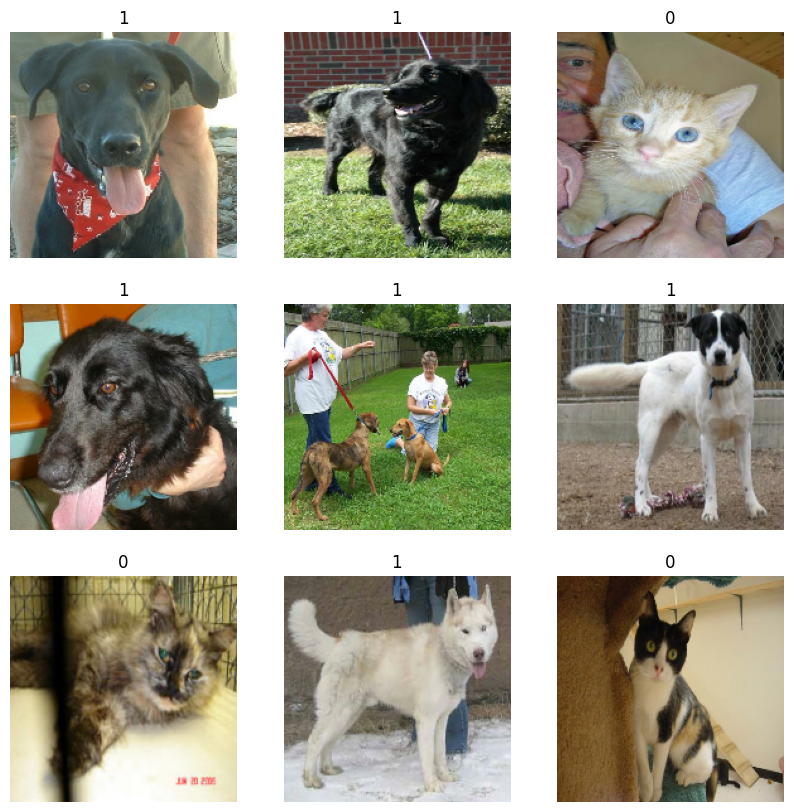

In [6]:
# Visualize the data 
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1): 
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

In [7]:
# Using image data augmentation

data_augmentation = keras.Sequential( 
    [ 
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

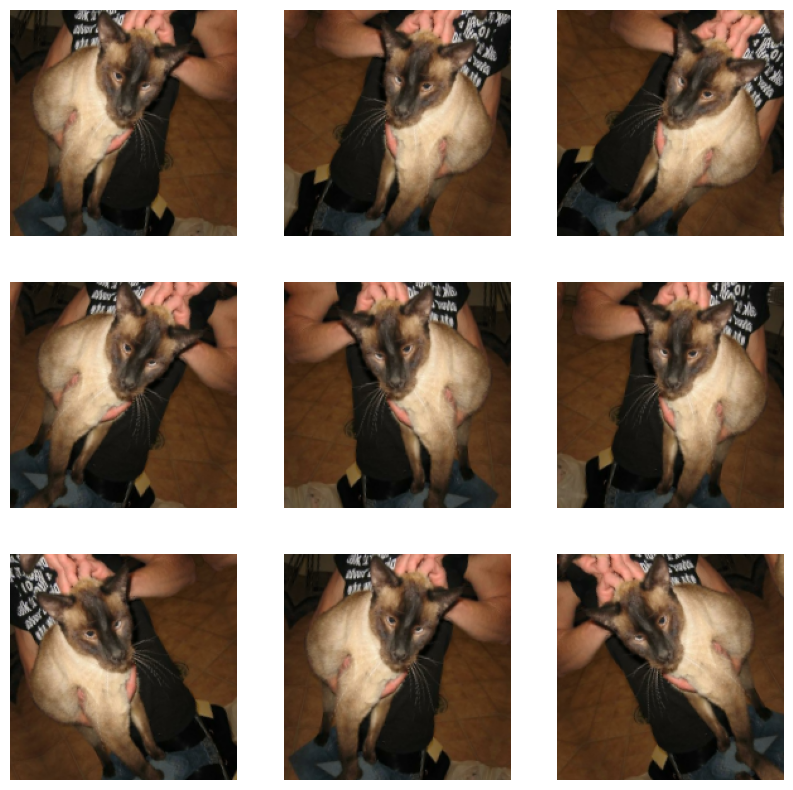

In [8]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1): 
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [11]:
# Standardizing the data

# Two option to preprocess the data
# 1. Make it part of the model - synchronously
# 2. apply it to the dataset - asynchronously


In [9]:
# Configure the dataset for performance 

# apply 'data augmentation' to the training images 
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls = tf.data.AUTOTUNE,
)
# prefetching samples in gpu memory helps maximize GPU utilization
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

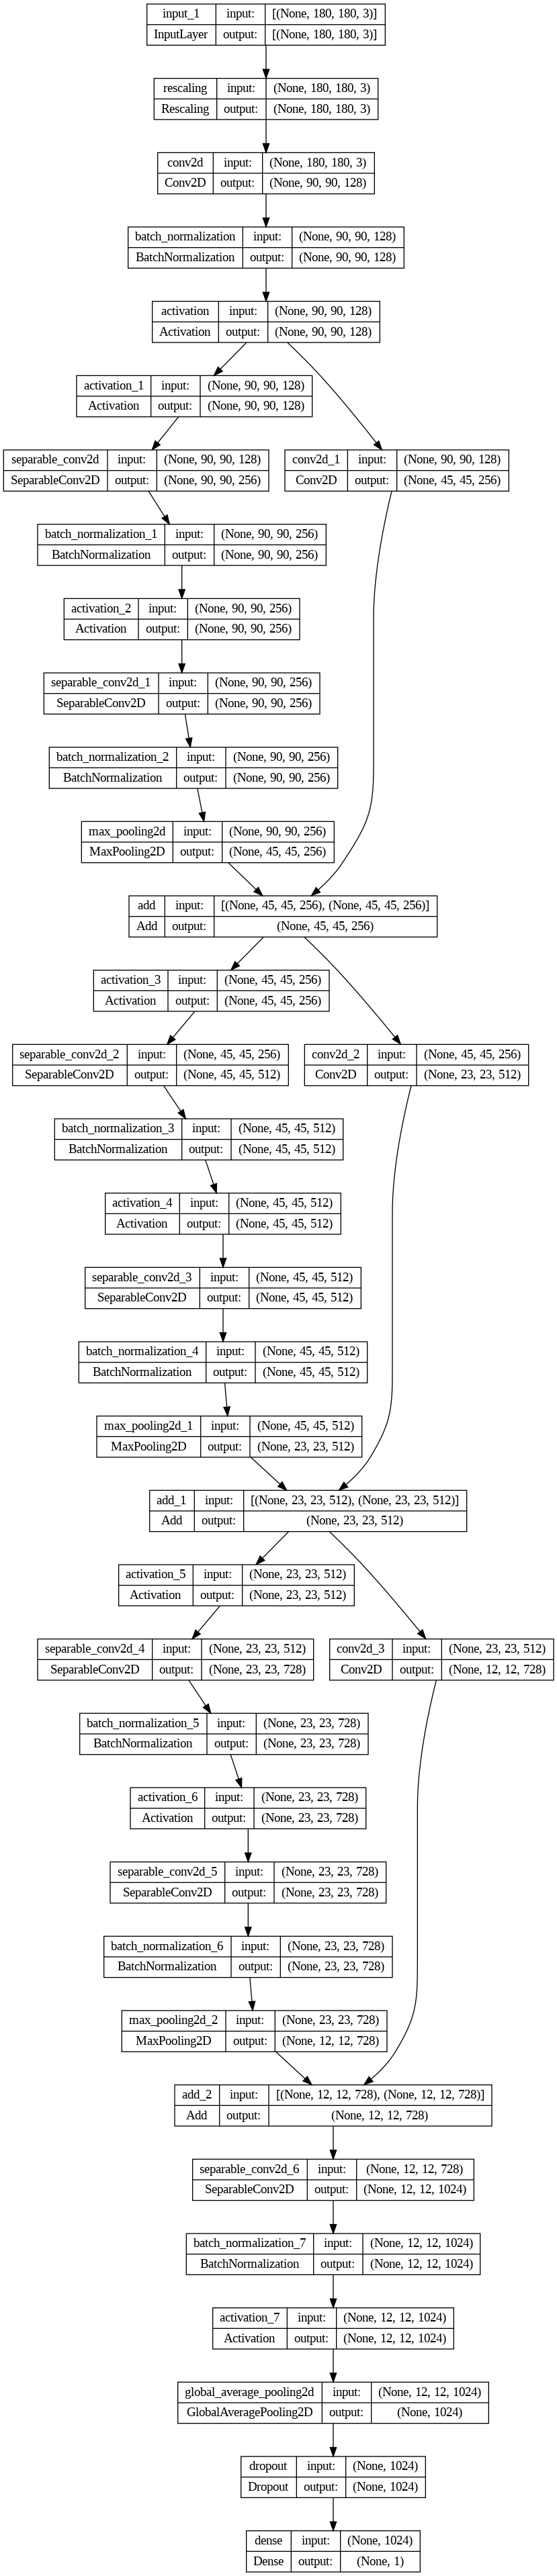

In [10]:
# Build a model 

def make_model(input_shape, num_classes): 
  inputs = keras.Input(shape=input_shape)

  # entry block 
  x = layers.Rescaling(1.0/255)(inputs) 
  x = layers.Conv2D(128, 3, strides=2, padding="same")(x) 
  x = layers.BatchNormalization()(x) 
  x = layers.Activation("relu")(x)

  previous_block_activation = x # set aside residual 

  for size in [256, 512, 728]: 
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x) 
    x = layers.BatchNormalization()(x) 
    
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x) 
    x = layers.BatchNormalization()(x) 

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x) 

    # Project residual 
    residual = layers.Conv2D(size, 1, strides=2, padding="same")(
        previous_block_activation
        )
    x = layers.add([x, residual]) # add back residual 
    previous_block_activation = x # set aside next residual 

  x = layers.SeparableConv2D(1024, 3, padding="same")(x)
  x = layers.BatchNormalization()(x) 
  x = layers.Activation("relu")(x) 

  x = layers.GlobalAveragePooling2D()(x) 
  if num_classes == 2:
    activation = "sigmoid"
    units = 1
  else: 
    activation = "softmax"
    unit = num_classes 

  x = layers.Dropout(0.5)(x) 
  outputs = layers.Dense(units, activation=activation)(x) 
  return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2) 
keras.utils.plot_model(model, show_shapes=True)


In [ ]:
# Train the model 
epochs = 5 
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")
] 
model.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss = "binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, 
    epochs=epochs, 
    callbacks=callbacks,
    validation_data=val_ds, 
)

Epoch 1/5
